In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

London bike sharing dataset
========
While exploring datasets on kaggle this one about bike share counts in London caught my eye. As someone who frequently commutes by bike in Denver I thought it'd be interesting to see what trends and predictions I could make given hourly counts and weather information found in this dataset.

The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour. The long duration shares are not taken in the count.

Metadata:
---

"timestamp" - timestamp field for grouping the data  
"cnt" - the count of a new bike shares  
"t1" - real temperature in C  
"t2" - temperature in C "feels like"  
"hum" - humidity in percentage  
"wind_speed" - wind speed in km/h  
"weather_code" - category of the weather  
"is_holiday" - boolean field - 1 holiday / 0 non holiday  
"is_weekend" - boolean field - 1 if the day is weekend  
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  

"weather_code" category description:  
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  
2 = scattered clouds / few clouds  
3 = Broken clouds  
4 = Cloudy  
7 = Rain/ light Rain shower/ Light rain  
10 = rain with thunderstorm  
26 = snowfall  
94 = Freezing Fog  


My first assumptions would be that given poor weather, ridership would be lower. Or vice versa, given favorable weather, more people would chose to utilize the bike share to get to work.

## Loading the data
The first step is to load the data and perform some basic cleaning. The dataset is in rather good condition so not much cleaning is required. However, it may be helpful to reformat certain columns into more friendly datatypes for further analysis. Additionally, expanding certain features such as 'timestamp' into separate columns allows for easier use in models.

In [55]:
# import data
bikeshare_data = pd.read_csv("data/london_merged_hour.csv")

# reformat timestamp
bikeshare_data['timestamp'] = pd.to_datetime(bikeshare_data['timestamp'])

# create new columns for date and time data
bikeshare_data['date'] = bikeshare_data['timestamp'].dt.normalize()
bikeshare_data['day_of_week'] = bikeshare_data['timestamp'].dt.dayofweek
bikeshare_data['hour'] = bikeshare_data['timestamp'].dt.hour

# rename columns
bikeshare_data = bikeshare_data.rename(columns={
    'cnt': 'count',
    't1': 'temperature_actual',
    't2': 'temperature_feels_like',
    'hum': 'humidity',
    'weather_code': 'weather_condition_code',
    'wind_speed': 'wind_speed',
    'is_holiday': 'is_holiday',
    'is_weekend': 'is_weekend',
    'season': 'season',
    'date': 'date'
})

# weather code
weather_code_map = {
    1:  "Clear or Fog",
    2:  "Few Clouds",
    3:  "Broken Clouds",
    4:  "Cloudy",
    7:  "Light Rain",
    10: "Thunderstorm with Rain",
    26: "Snowfall",
    94: "Freezing Fog"
}

# include weather description for each entry
bikeshare_data['weather_description'] = bikeshare_data['weather_condition_code'].map(weather_code_map)


## Data visualization
To get an understanding of the dataset and what features may be useful in a model, I created some basic visualizations such as a correlation heatmap and pairplots. This will help show what features correlate to counts.

<Figure size 640x480 with 0 Axes>

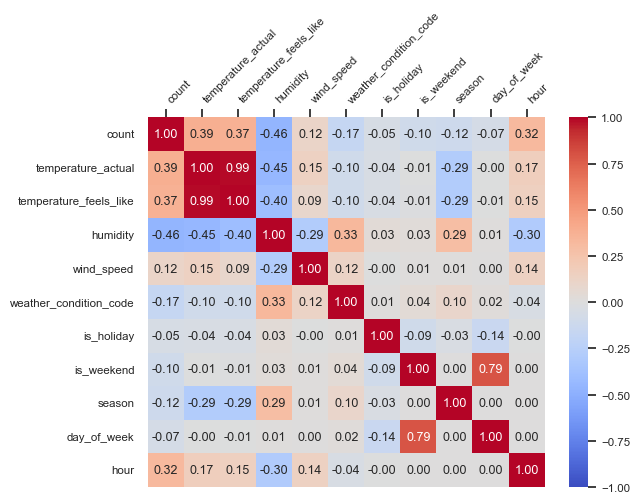

<Figure size 640x480 with 0 Axes>

In [48]:
sns.set_theme(font_scale=.75)
sns.color_palette("coolwarm", as_cmap=True)
hm = sns.heatmap(data=bikeshare_data.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, center=0, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='.2f')

hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')  # optional: move x-axis label too
plt.xticks(rotation=45, ha='left')  # rotate for better readability
plt.yticks(rotation=0)   # keep y labels horizontal

plt.figure()

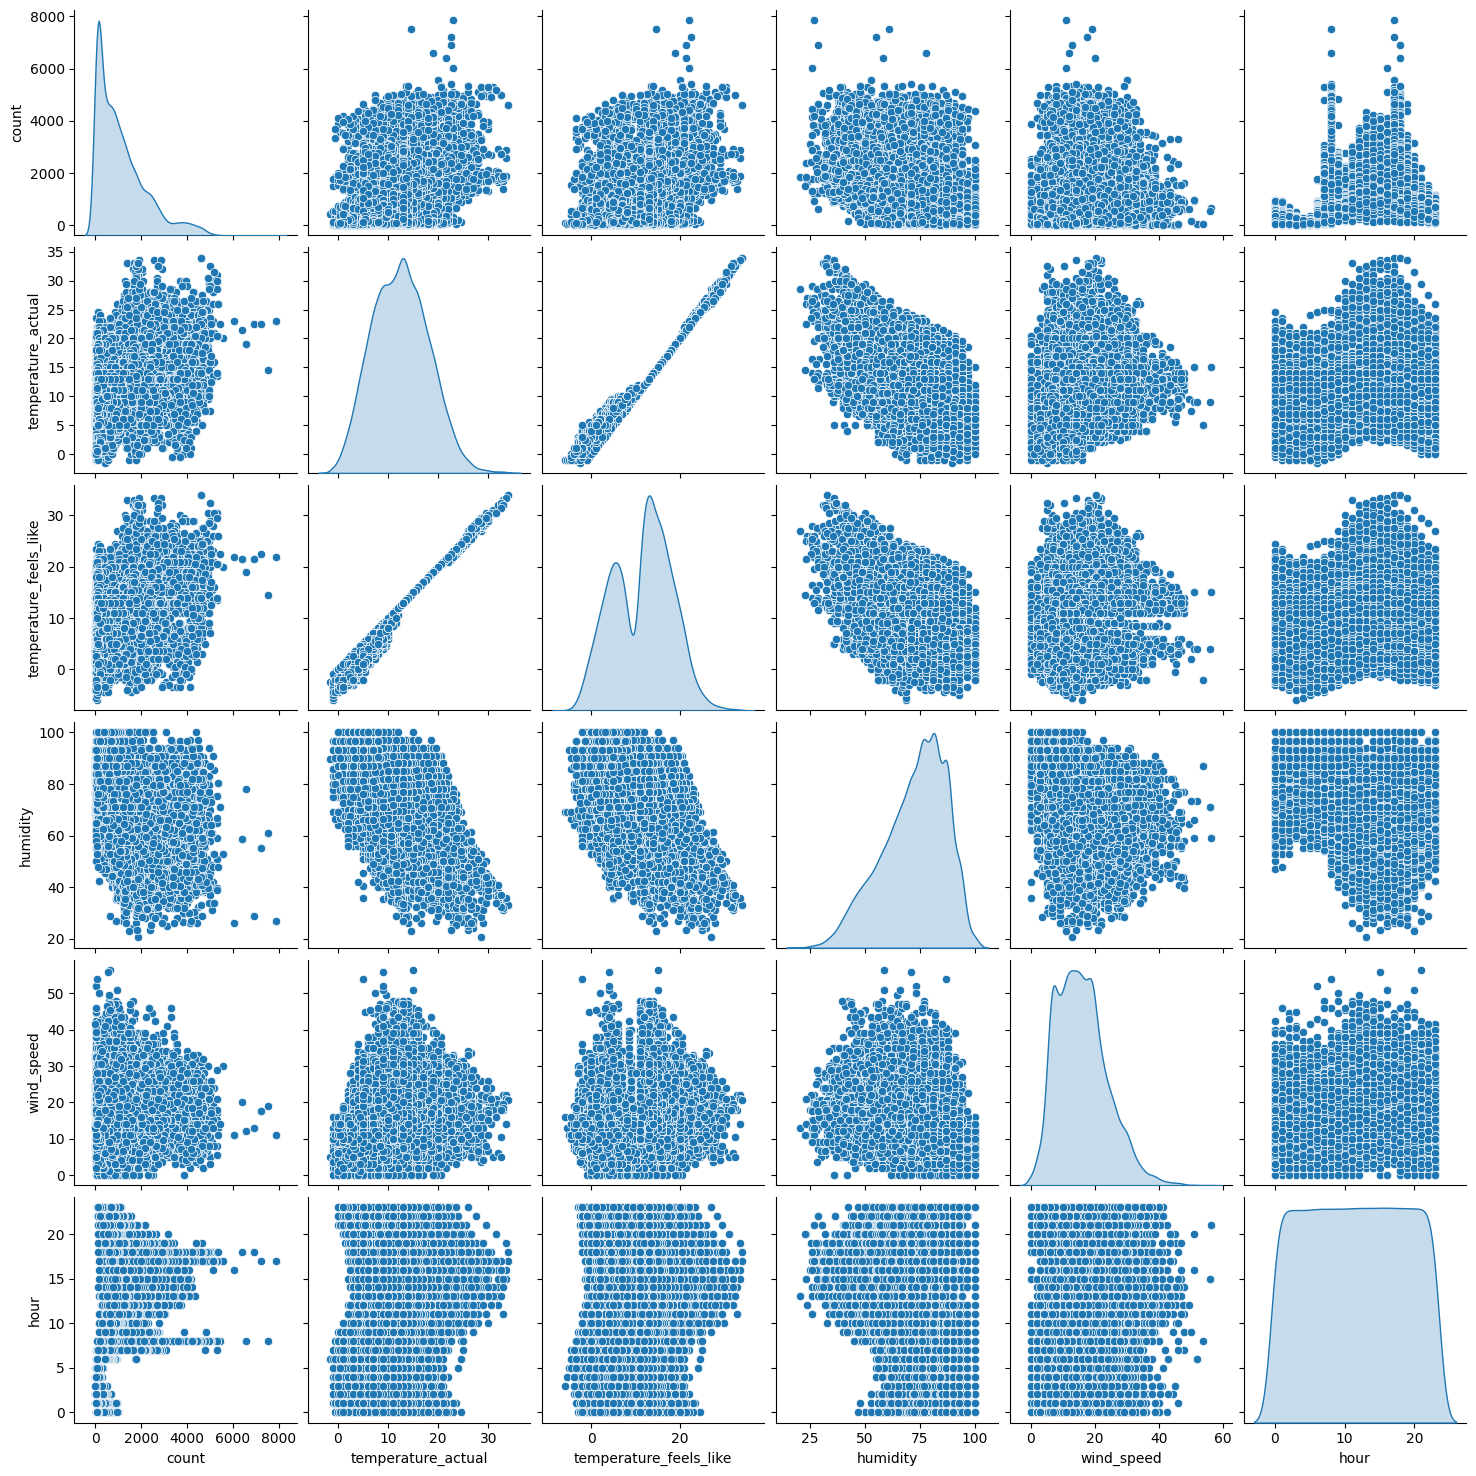

In [33]:
pair_plot_columns = ['count', 'temperature_actual', 'temperature_feels_like', 'humidity', 'wind_speed', 'hour']

sns.pairplot(bikeshare_data[pair_plot_columns], diag_kind='kde')
plt.show()

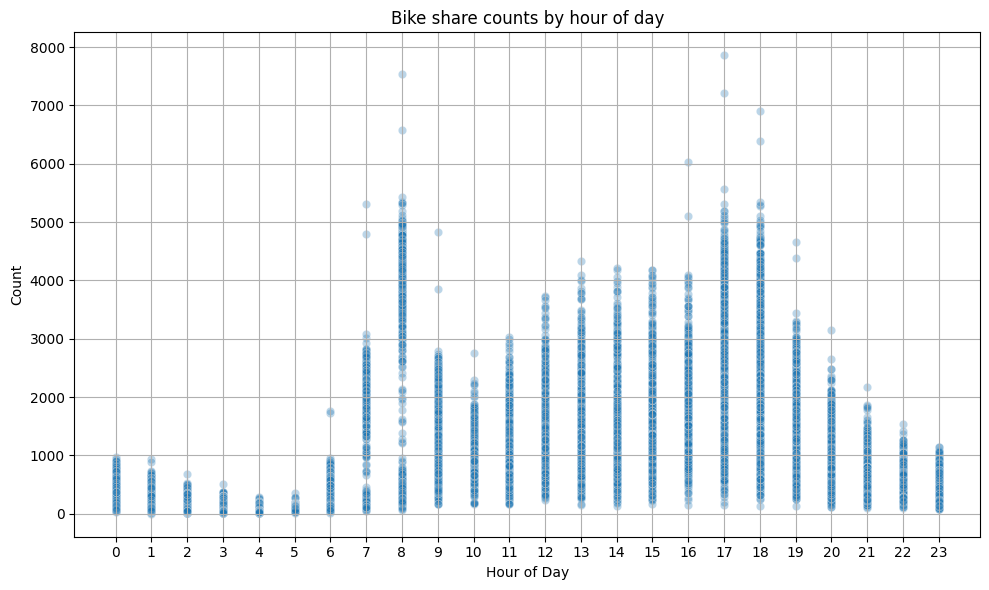

In [ ]:
# To get a general idea of when riders are choosing to utilize the bike share.
# As expected, there are slightly higher counts at 8am and 5pm indicating commuter use.

# scatter plot of counts by hour
plt.figure(figsize=(10,6))
sns.scatterplot(data=bikeshare_data, x='hour', y='count', alpha=0.3)
plt.title('Bike share counts by hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

## Models

Given that most variable types are numeric such as certain weather indicators, it made sense to start with basic linear regression models.

As shown below, using a single feature such as 'temperature_actual' proved to be a pretty poor predictor for ridership counts. Despite showing the highest correlation to count from other features, it wasn't a very accurate predictor of counts.

Utilizing multiple weather features including 'temperature_actual, humidity, and wind speed' didn't fair much better.



Note - despite temperature_feels also showing a relatively high correlation to count it was not included since temperature_actual and temperature_feels are highly correlated

In [56]:
# create training and test sets
X_train, X_test = train_test_split(bikeshare_data, test_size=0.20)

# run a simple linear regression model using temp_actual as the predictor
model = smf.ols(formula='count ~ temperature_actual', data=X_train)

model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2486.
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        22:19:37   Log-Likelihood:            -1.1599e+05
No. Observations:               13931   AIC:                         2.320e+05
Df Residuals:                   13929   BIC:                         2.320e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            199.0615     20

In [59]:
# run a multilinear regression model using multiple features
model_multi = smf.ols(formula='count ~ temperature_actual + humidity + wind_speed', data=X_train)

model_multi = model_multi.fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     1587.
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        22:21:38   Log-Likelihood:            -1.1508e+05
No. Observations:               13931   AIC:                         2.302e+05
Df Residuals:                   13927   BIC:                         2.302e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2642.6877     63

Another model may be better suited than simple regression models. Through trial 

In [10]:
# random forest model
bikeshare_data_model = bikeshare_data.drop(columns=['timestamp', 'date', 'weather_description'])

# setup the features and target
X = bikeshare_data_model.drop(columns=['count'])
y = bikeshare_data_model['count']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 237.36
R² Score: 0.9530


In [80]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

# Metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 251.42
R² Score: 0.9472


In [60]:
# use weather data to predict counts
# get counts for hours 8am and 5pm
# average weather somehow

hour_8am_data = bikeshare_data[
    (bikeshare_data['hour'] == 8) &
    (bikeshare_data['is_weekend'] == 0) &
    (bikeshare_data['is_holiday'] == 0)
].copy()

hour_8am_data.drop(columns=['hour', 'is_holiday', 'is_weekend'], inplace=True)



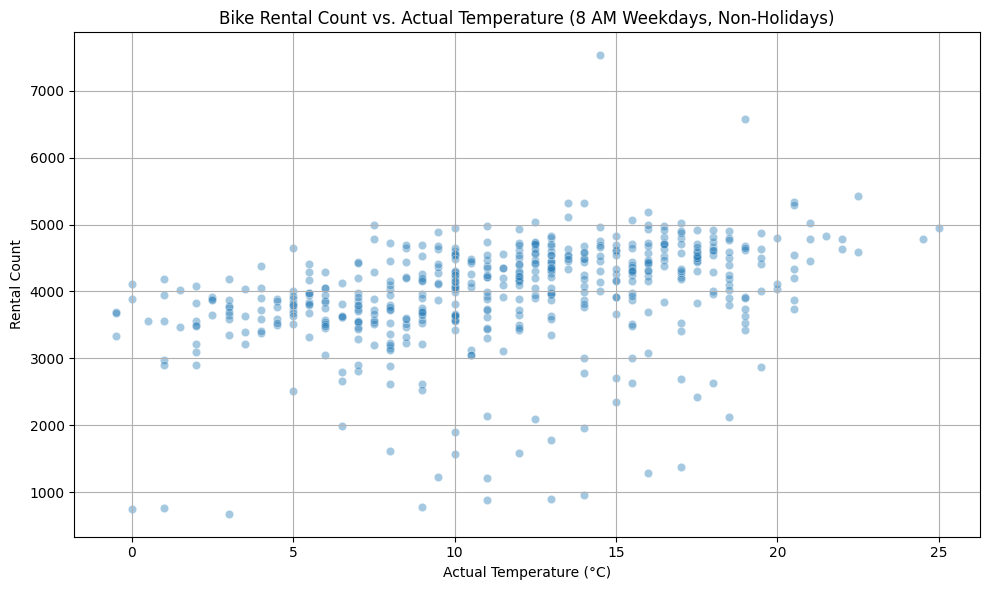

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=hour_8am_data,
    x='temperature_actual',
    y='count',
    alpha=0.4
)
plt.title('Bike Rental Count vs. Actual Temperature (8 AM Weekdays, Non-Holidays)')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.tight_layout()
plt.show()

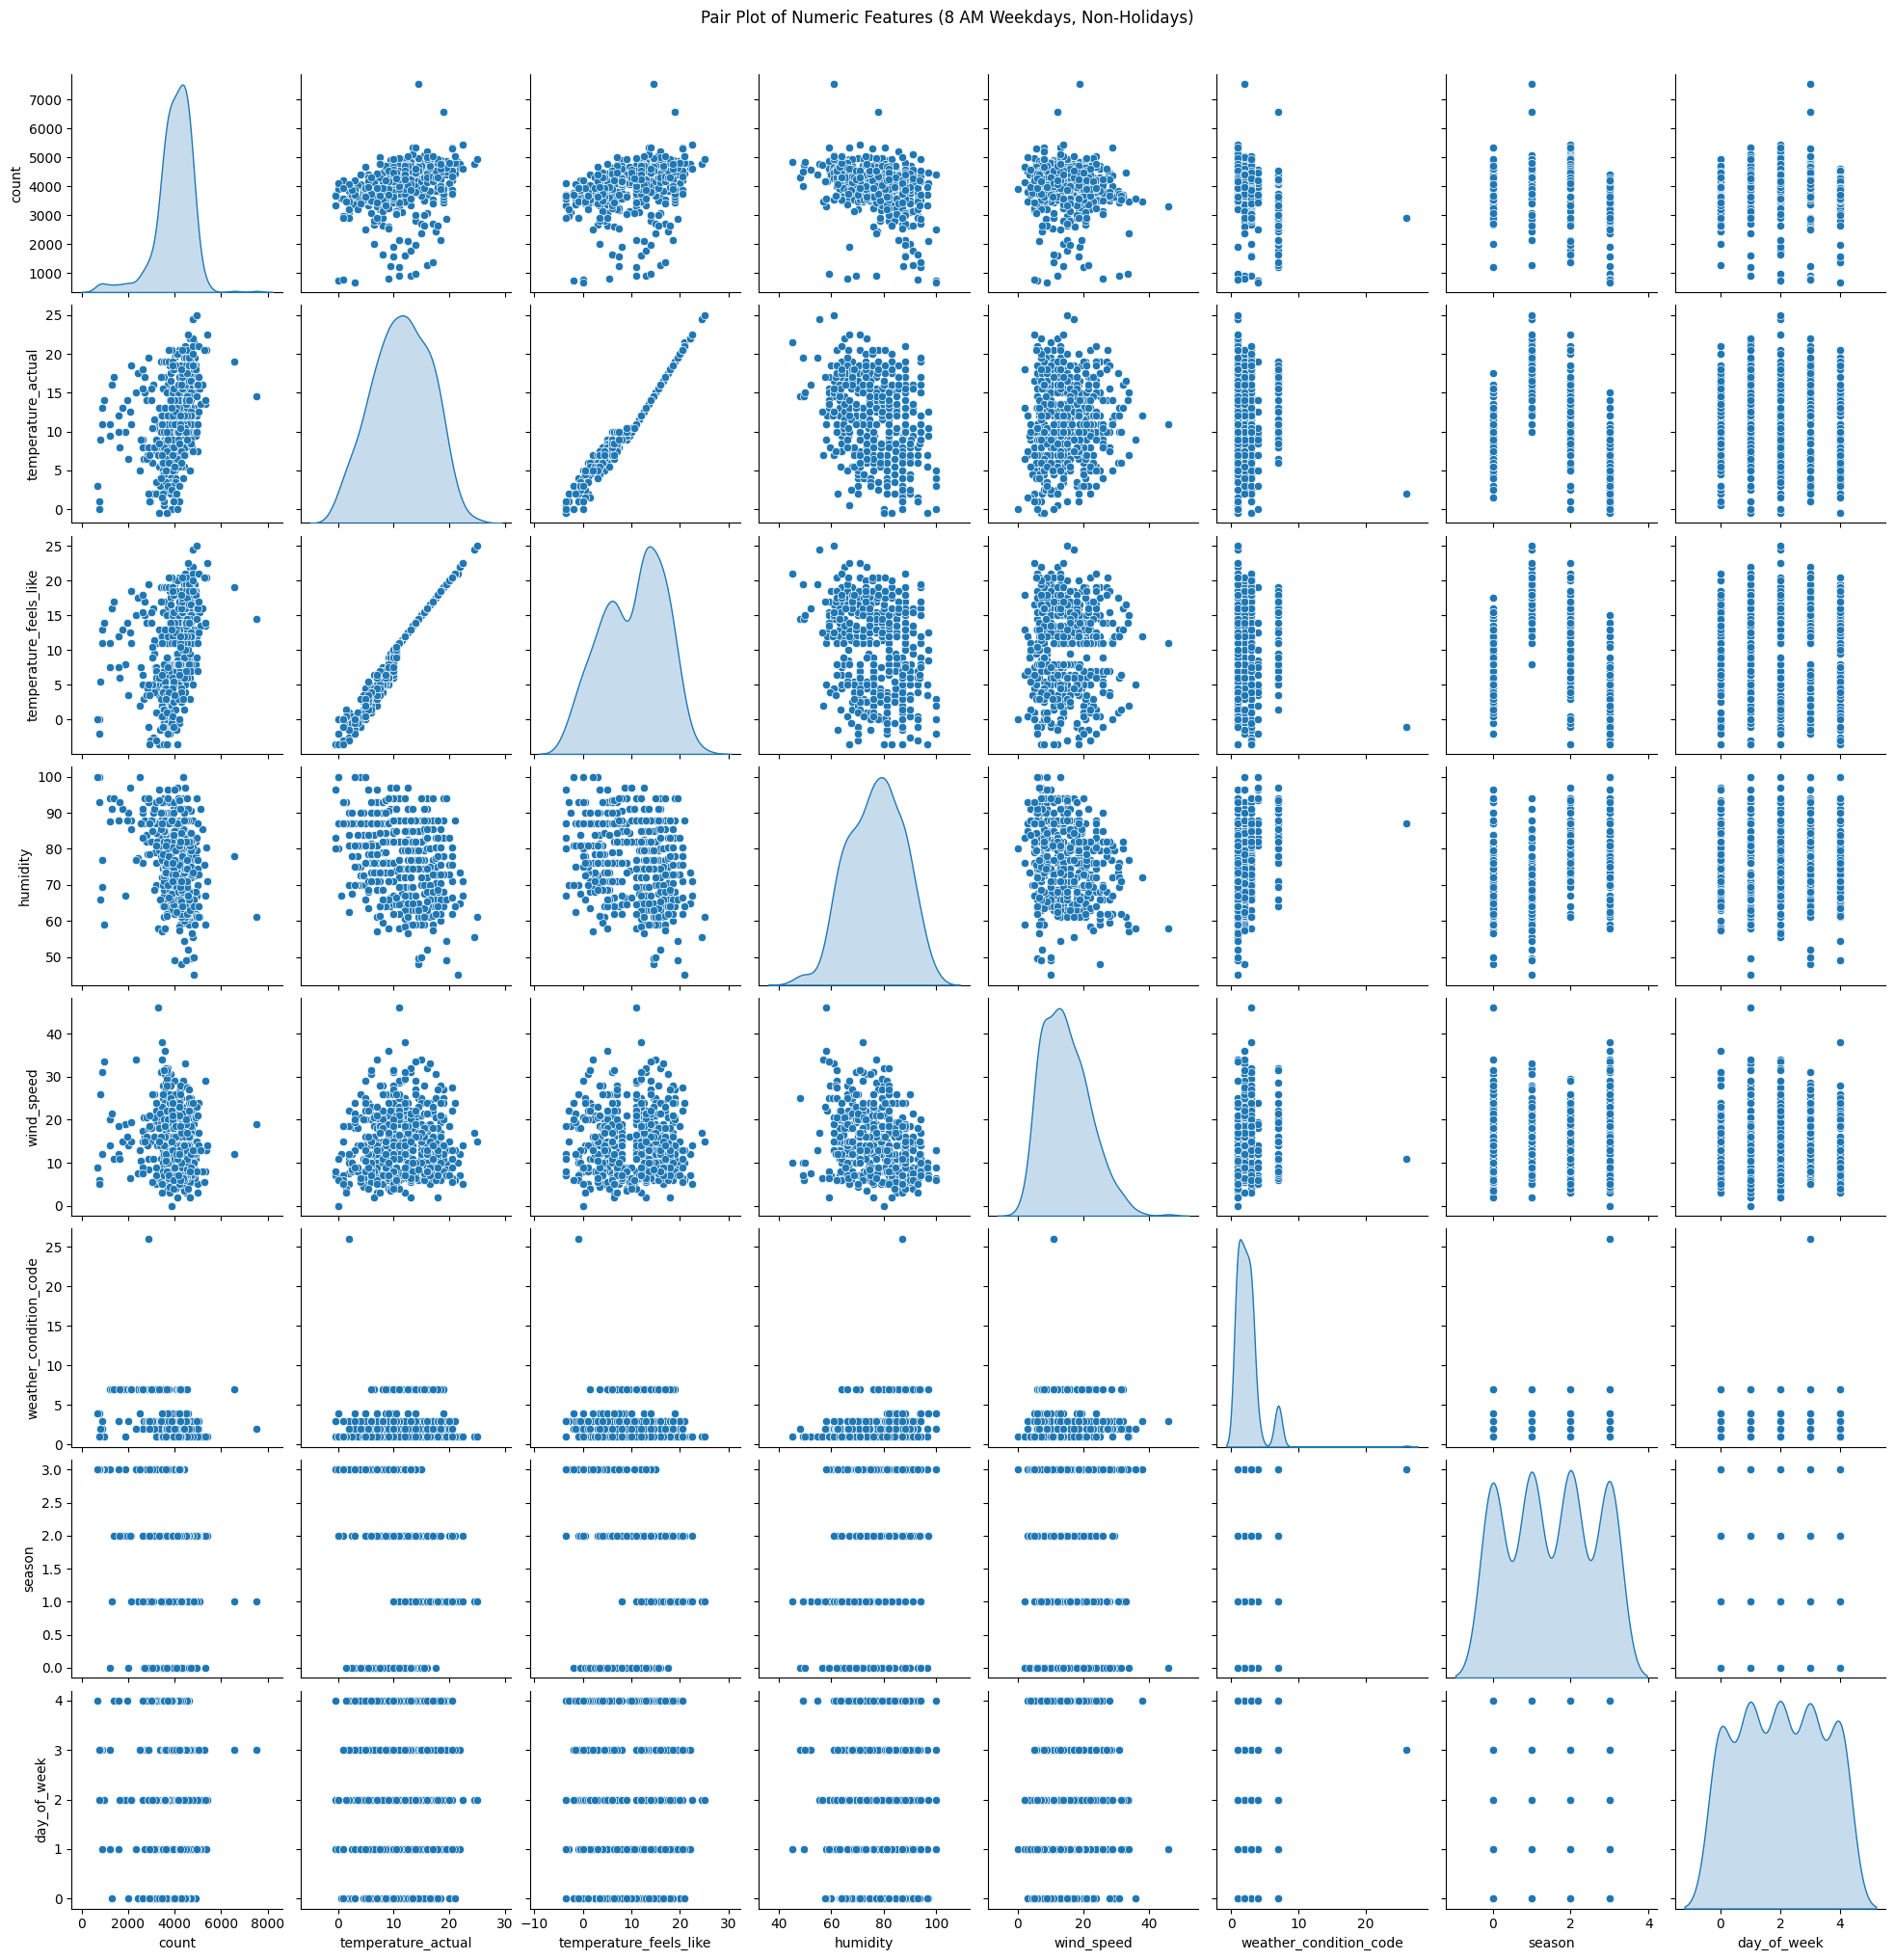

In [17]:
numeric_cols = hour_8am_data.select_dtypes(include='number')

# Create pair plot
sns.pairplot(numeric_cols, diag_kind='kde')
plt.suptitle('Pair Plot of Numeric Features (8 AM Weekdays, Non-Holidays)', y=1.02)
plt.show()

In [ ]:
# using a subset of data run our multilinear regression using multiple features
model_multi_hour = smf.ols(formula='count ~ temperature_actual + humidity + wind_speed + weather_condition_code', data=hour_8am_data)

model_multi_hour = model_multi_hour.fit()
print(model_multi_hour.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     56.03
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           5.27e-39
Time:                        22:57:44   Log-Likelihood:                -3973.2
No. Observations:                 502   AIC:                             7956.
Df Residuals:                     497   BIC:                             7978.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5146

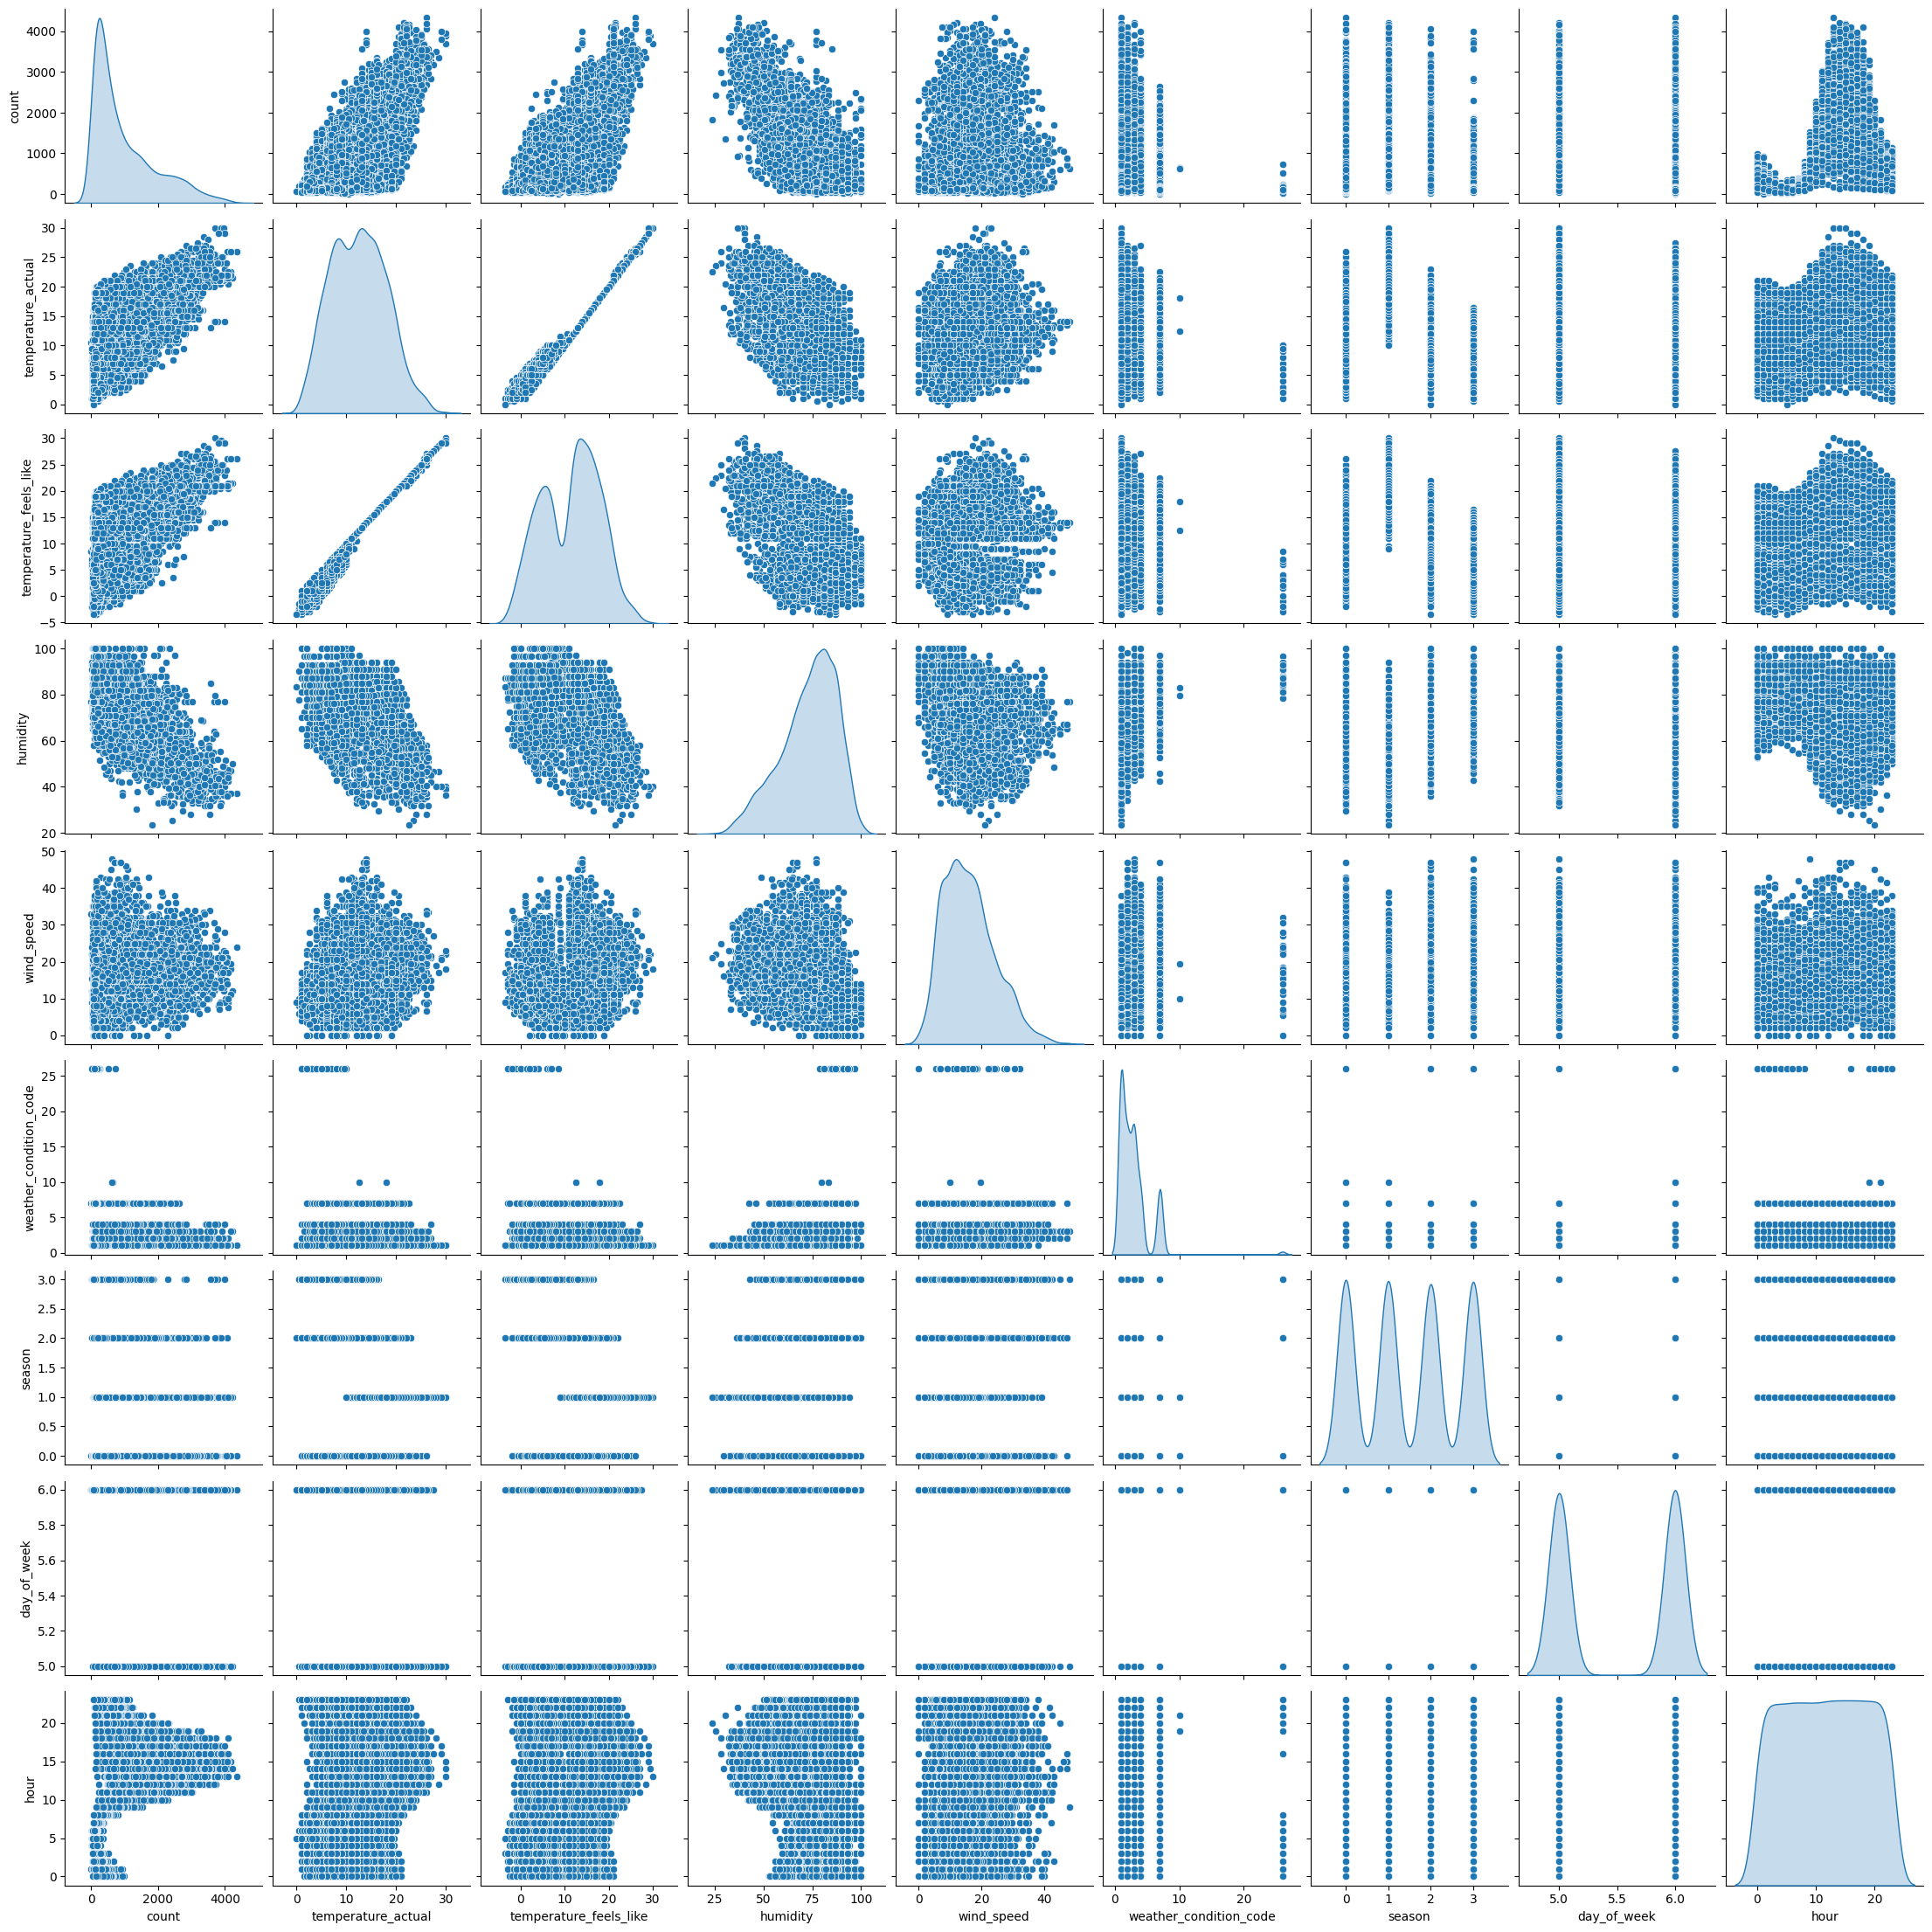

In [47]:
# select only weekend days
bikeshare_data_weekend = bikeshare_data[(bikeshare_data['is_weekend'] == 1)].copy()

bikeshare_data_weekend.drop(columns=['is_holiday', 'is_weekend'], inplace=True)

numeric_cols_weekend = bikeshare_data_weekend.select_dtypes(include='number')

# Create pair plot
sns.pairplot(numeric_cols_weekend, diag_kind='kde')
plt.show()

<Figure size 640x480 with 0 Axes>

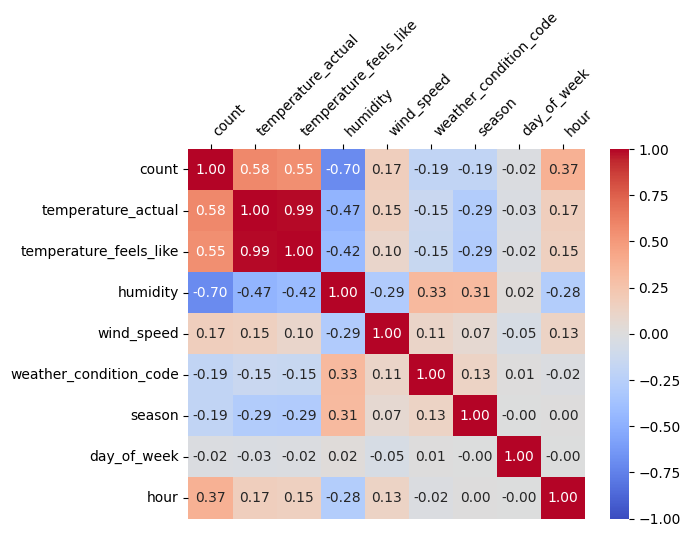

<Figure size 640x480 with 0 Axes>

In [ ]:
hm_weekend = sns.heatmap(data=bikeshare_data_weekend.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, center=0, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='.2f')

hm_weekend.xaxis.set_ticks_position('top')
hm_weekend.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)

plt.figure()

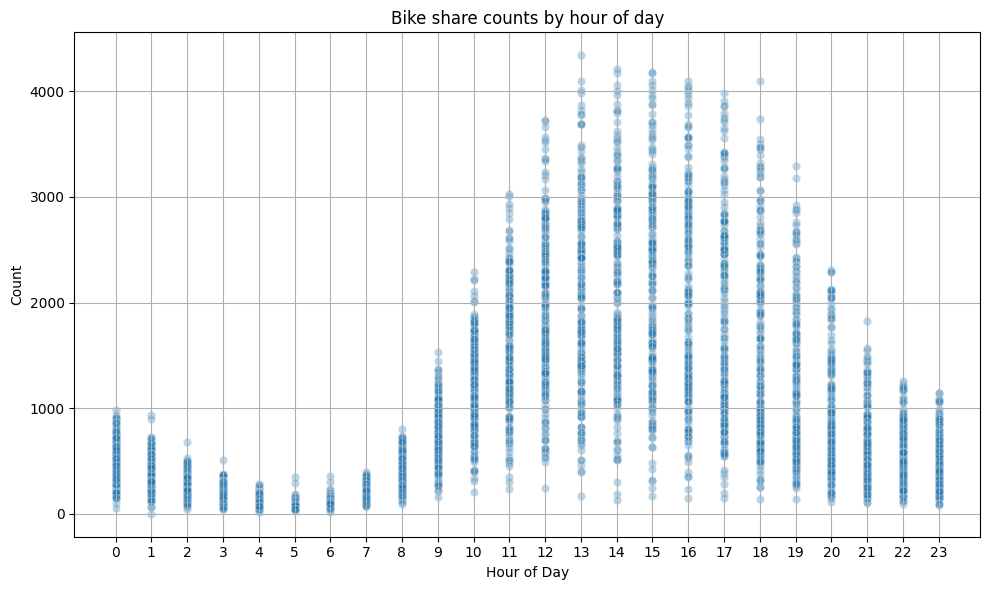

In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=bikeshare_data_weekend, x='hour', y='count', alpha=0.3)
plt.title('Bike share counts by hour of day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# using a subset of data run our multilinear regression using multiple features
model_weekend = smf.ols(formula='count ~ temperature_actual + humidity + wind_speed + hour', data=bikeshare_data_weekend)

model_weekend = model_weekend.fit()
print(model_weekend.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     1910.
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        21:32:26   Log-Likelihood:                -38682.
No. Observations:                4970   AIC:                         7.737e+04
Df Residuals:                    4965   BIC:                         7.741e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2618.2850     71